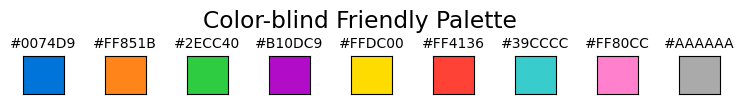

In [3]:
import re
import sys
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.weight'] = 'normal' 
plt.rcParams['font.size'] = 14

from tqdm import tqdm
from dataclasses import dataclass
from pathlib import Path
from scipy.interpolate import interp1d
from collections import defaultdict
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.axisartist.axislines import AxesZero

HOME = Path.cwd().parent
sys.path.append(str(HOME))

from src.data import BatteryData
from src.builders import MODELS
from src.utils import import_config

pd.options.display.precision = 1
palette = [
    '#0074D9',  # blue
    '#FF851B',  # orange
    '#2ECC40',  # green
    '#B10DC9',  # purple
    '#FFDC00',  # yellow
    '#FF4136',  # red
    '#39CCCC',  # teal
    '#FF80CC',  # pink
    '#AAAAAA',  # gray
]
# Show palette
fig, axes = plt.subplots(1, len(palette), figsize=(len(palette), 0.5))
for color, ax in zip(palette, axes):
    ax.set_facecolor(color)
    ax.set_title(color, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle('Color-blind Friendly Palette', y=1.8)
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

Reproduce Figure 1 elements.

In [5]:
path = (HOME / 'data/processed/').glob('*/*')
all_batteries = [
    BatteryData.load(p) for p in tqdm(
        list(path), desc='Load cells'
    )
]
material_map = defaultdict(list)
for cell in all_batteries:
    material_map[cell.cathode_material].append(cell)

Load cells: 100%|██████████| 403/403 [02:57<00:00,  2.27it/s]


In [6]:
# Helper functions
def get_V_of_Qd(cycle_data, C, interp_dims=1000, mode='discharge', xe=1.):
    I = np.array(cycle_data.current_in_A)  # noqa
    V = np.array(cycle_data.voltage_in_V)
    Qc = np.array(cycle_data.charge_capacity_in_Ah) / C
    Qd = np.array(cycle_data.discharge_capacity_in_Ah) / C

    charge_mask, discharge_mask = I > 0.1, I < -0.1
    Qc, Qd = Qc[charge_mask], Qd[discharge_mask]
    Ic, Id = I[charge_mask], I[discharge_mask]
    Vc, Vd = V[charge_mask], V[discharge_mask]
    # V(Qc), V(Qd), I(Qc), I(Qd)
    res = interpolate( Qd, Vd, interp_dims, mode, 0., xe)
    return res

def get_features(cycle_data, C, interp_dims=1000, mode='discharge', xe=1.):
    I = np.array(cycle_data.current_in_A)  # noqa
    V = np.array(cycle_data.voltage_in_V)
    Qc = np.array(cycle_data.charge_capacity_in_Ah) / C
    Qd = np.array(cycle_data.discharge_capacity_in_Ah) / C

    charge_mask, discharge_mask = I > 0.1, I < -0.1
    Qc, Qd = Qc[charge_mask], Qd[discharge_mask]
    Ic, Id = I[charge_mask], I[discharge_mask]
    Vc, Vd = V[charge_mask], V[discharge_mask]
    # V(Qc), V(Qd), I(Qc), I(Qd)
    cycle_feature = [
        interpolate(
            Qc, Vc, interp_dims, 'charge', xe=xe),
        interpolate(
            Qd, Vd, interp_dims, 'discharge', xe=xe),
        interpolate(Qc, Ic, interp_dims, xe=xe),
        interpolate(Qd, Id, interp_dims, xe=xe),
    ]
    # delta_V(Q)
    cycle_feature.append(
        cycle_feature[0] - cycle_feature[1][::-1]
    )
    # R(Q)
    cycle_feature.append(
        (cycle_feature[0] - cycle_feature[1][::-1])
        / (cycle_feature[2] - cycle_feature[3][::-1] + 1e-3)
    )
    return np.stack(cycle_feature)

def interpolate(x, y, interp_dims, fill_type='', xs=0, xe=1.):
    if len(x) <= 2:
        return np.zeros(interp_dims)
    mask = (x >= xs) & (x <= xe)
    x, y = x[mask], y[mask]
    if fill_type == 'charge':
        fill_values = (y.min(), y.max())
    elif fill_type == 'discharge':
        fill_values = (y.max(), y.min())
    else:
        fill_values = float('nan')
    func = interp1d(
        x, y,
        kind='linear',
        bounds_error=False,
        fill_value=fill_values)
    return func(np.linspace(xs, xe, interp_dims))

def get_cycle_life(cell_data, ths=0.8):
    ths = cell_data.nominal_capacity_in_Ah * ths
    for i in range(len(cell_data.cycle_data)):
        if max(cell_data.cycle_data[i].discharge_capacity_in_Ah) <= ths:
            break
    return i

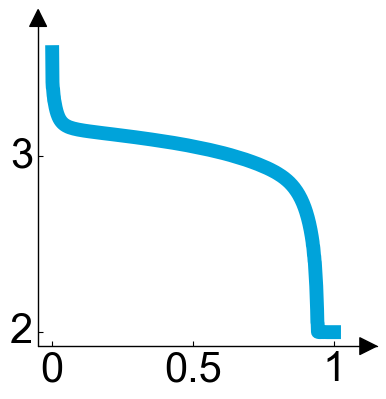

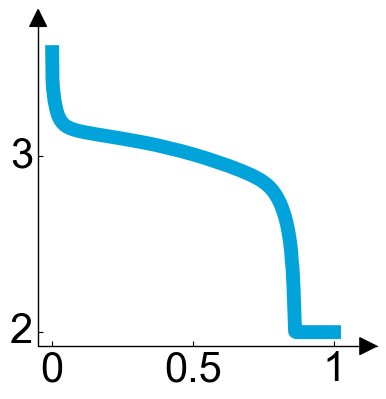

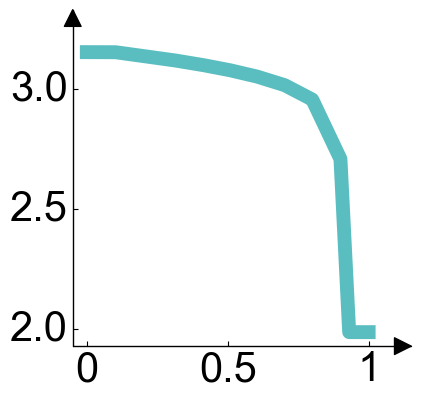

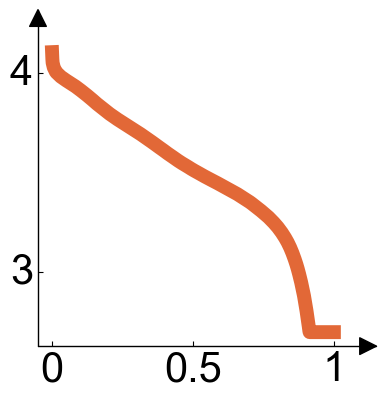

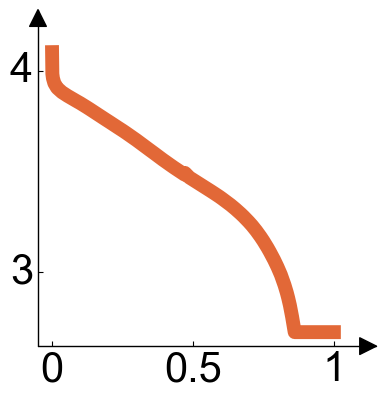

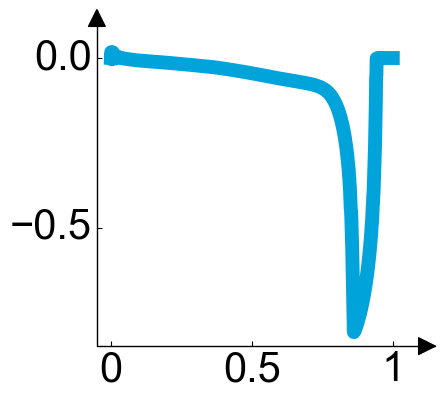

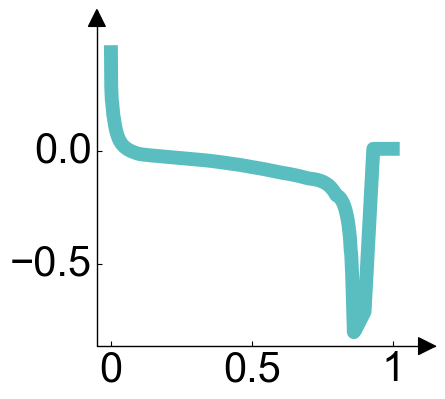

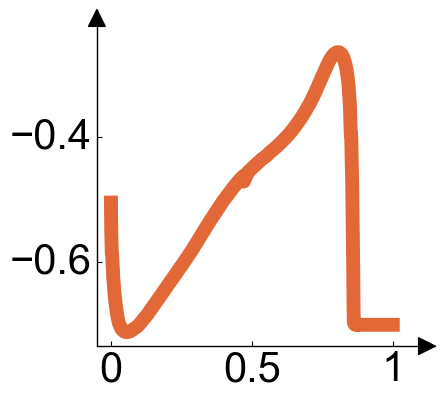

In [4]:
lfp_min_cell, lfp_max_cell = None, None
for cell in material_map['LFP']:
    if lfp_max_cell is None or len(cell.cycle_data) > len(lfp_max_cell.cycle_data):
        lfp_max_cell = cell
    if lfp_min_cell is None or len(cell.cycle_data) < len(lfp_min_cell.cycle_data):
        lfp_min_cell = cell
lco_cell = list(sorted(
    material_map['LCO'], key=lambda x: x.cell_id
))[-7]

lfp_min_feat_10 = get_V_of_Qd(
    lfp_min_cell.cycle_data[9], lfp_min_cell.nominal_capacity_in_Ah)
lfp_min_feat_100 = get_V_of_Qd(
    lfp_min_cell.cycle_data[99], lfp_min_cell.nominal_capacity_in_Ah)
lfp_max_feat_100 = get_V_of_Qd(
    lfp_max_cell.cycle_data[99], lfp_max_cell.nominal_capacity_in_Ah)
lco_feat_10 = get_V_of_Qd(
    lco_cell.cycle_data[9], lco_cell.nominal_capacity_in_Ah)
lco_feat_100 = get_V_of_Qd(
    lco_cell.cycle_data[99], lco_cell.nominal_capacity_in_Ah)

plt.rcParams['font.size'] = 30
methods = [
    'lfp_min_feat_10',
    'lfp_min_feat_100',
    'lfp_max_feat_100',
    'lco_feat_10',
    'lco_feat_100',
    'lfp_min_feat_100-lfp_min_feat_10',
    'lfp_min_feat_100-lfp_max_feat_100',
    'lfp_min_feat_100-lco_feat_100',
    ]
colors = ['#00A3DA', '#00A3DA', '#5ABEC1', '#E26837', '#E26837',
          '#00A3DA', '#5ABEC1', '#E26837']
for method, color in zip(methods, colors):
    curve = eval(method)
    fig= plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(axes_class=AxesZero)
    ax.plot(curve, color=color, linewidth=10)
    plt.xticks([0, 500, 1000], ['0', '0.5', '1'])
    ax.axis['bottom'].set_axisline_style('-|>')
    ax.axis['left'].set_axisline_style('-|>')
    ax.axis['top'].set_visible(False)
    ax.axis['right'].set_visible(False)
    if method == 'lco_feat_100':
        ax.set_yticks([3, 4])
    fig.savefig(HOME / f'data/{method}.svg',
                bbox_inches='tight', pad_inches=0.1)
    plt.show()

plt.rcParams['font.size'] = 14

In [ ]:
lfp_min_cell, lfp_max_cell = None, None
for cell in material_map['LFP']:
    if lfp_max_cell is None or len(cell.cycle_data) > len(lfp_max_cell.cycle_data):
        lfp_max_cell = cell
    if lfp_min_cell is None or len(cell.cycle_data) < len(lfp_min_cell.cycle_data):
        lfp_min_cell = cell
lco_cell = list(sorted(
    material_map['LCO'], key=lambda x: x.cell_id
))[-7]

lfp_min_feat_10 = get_V_of_Qd(
    lfp_min_cell.cycle_data[9], lfp_min_cell.nominal_capacity_in_Ah)
lfp_min_feat_100 = get_V_of_Qd(
    lfp_min_cell.cycle_data[99], lfp_min_cell.nominal_capacity_in_Ah)
lfp_max_feat_100 = get_V_of_Qd(
    lfp_max_cell.cycle_data[99], lfp_max_cell.nominal_capacity_in_Ah)
lco_feat_10 = get_V_of_Qd(
    lco_cell.cycle_data[9], lco_cell.nominal_capacity_in_Ah)
lco_feat_100 = get_V_of_Qd(
    lco_cell.cycle_data[99], lco_cell.nominal_capacity_in_Ah)

plt.rcParams['font.size'] = 30
methods = [
    'lfp_min_feat_10',
    'lfp_min_feat_100',
    'lfp_max_feat_100',
    'lco_feat_10',
    'lco_feat_100',
    'lfp_min_feat_100-lfp_min_feat_10',
    'lfp_min_feat_100-lfp_max_feat_100',
    'lfp_min_feat_100-lco_feat_100',
    ]
colors = ['#00A3DA', '#00A3DA', '#5ABEC1', '#E26837', '#E26837',
          '#00A3DA', '#5ABEC1', '#E26837']
for method, color in zip(methods, colors):
    curve = eval(method)
    fig= plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(axes_class=AxesZero)
    ax.plot(curve, color=color, linewidth=10)
    plt.xticks([0, 500, 1000], ['0', '0.5', '1'])
    ax.axis['bottom'].set_axisline_style('-|>')
    ax.axis['left'].set_axisline_style('-|>')
    ax.axis['top'].set_visible(False)
    ax.axis['right'].set_visible(False)
    if method == 'lco_feat_100':
        ax.set_yticks([3, 4])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    fig.savefig(HOME / f'data/visualization/{method}.svg',
                bbox_inches='tight', pad_inches=0.1)
    plt.show()

plt.rcParams['font.size'] = 14


Process LFP cells: 100%|██████████| 275/275 [00:03<00:00, 71.11it/s]


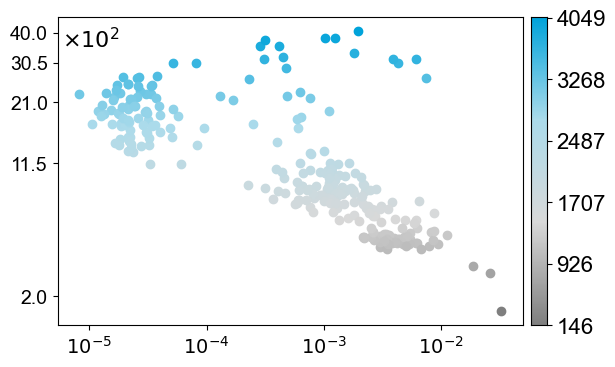

In [5]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#7F7F7F', '#D9D9D9', '#ABDBEB', '#00A3DA'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.rcParams['font.size'] = 16
vars_, labels = [], []
for cell in tqdm(material_map['LFP'], desc='Process LFP cells'):
    q10 = get_V_of_Qd(cell.cycle_data[9], cell.nominal_capacity_in_Ah)
    q100 = get_V_of_Qd(cell.cycle_data[99], cell.nominal_capacity_in_Ah)
    var = np.var(q100 - q10)
    label = get_cycle_life(cell)
    vars_.append(np.log10(var))
    labels.append(label)
max_labels, min_labels = max(labels), min(labels)
labels = np.array(labels)
labels = np.log10(labels - min_labels + 400)
yticks = np.linspace(200, 4000, 5)
yticks = np.log10(yticks - min_labels + 400)
gap = labels.max() - labels.min()
for var, label in zip(vars_, labels):
    ax.scatter(var, label, color=cmap((label - labels.min()) / gap))
ax.set_yticks(yticks, labels=[round(10**y-400+min_labels)/100 for y in yticks])
x_pos = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 1e-2
y_pos = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) / 10
ax.text(x_pos, y_pos, '$\\times 10^2$')

xticks = [-2, -3, -4, -5]
ax.set_xticks(xticks, [f'$10^{{{x}}}$' for x in xticks])

# For color bar
cax = ax.inset_axes([1.01, 0, 0.05, 1.])
cax.yaxis.tick_right()
cax.yaxis.set_label_position('right')
cax.set_xticks([])
img = torch.linspace(1, 0, 1000)[None].T.expand(-1, 50)
cax.imshow(img, cmap=cmap)
yticks = [0, 200, 400, 600, 800, 1000]
labels = [
    int((x/1000) * (max_labels - min_labels) + min_labels) for x in yticks]
cax.set_yticks(yticks, labels=labels[::-1])
fig.savefig(
    HOME / f'data/stats_self_diff_square.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

Process LFP cells: 100%|██████████| 275/275 [00:03<00:00, 75.01it/s] 


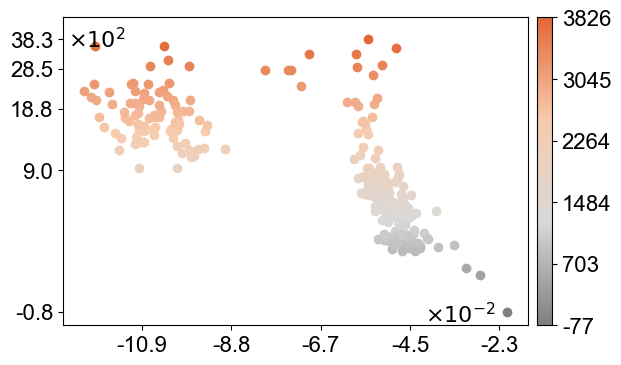

In [6]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#7F7F7F', '#D9D9D9', '#F7CCAE', '#E26837'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

cycle = 99
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.rcParams['font.size'] = 16
vars_, labels = [], []

base_cell = list(sorted(
    material_map['LCO'], key=lambda x: x.cell_id
))[-7]
base_100 = get_V_of_Qd(
    base_cell.cycle_data[cycle], base_cell.nominal_capacity_in_Ah)
base_label = get_cycle_life(base_cell)

for cell in tqdm(material_map['LFP'], desc='Process LFP cells'):
    label_diff = get_cycle_life(cell) - base_label
    q100 = get_V_of_Qd(cell.cycle_data[cycle], cell.nominal_capacity_in_Ah)
    feat = (q100 - base_100)
    signed_var = np.sign(np.median(feat)) * np.log10(np.var(feat) + 1)
    vars_.append(signed_var)
    labels.append(label_diff)
max_labels, min_labels = max(labels), min(labels)
labels = np.array(labels)
labels = np.log10(labels - min_labels + 400)
gap = labels.max() - labels.min()
for var, label in zip(vars_, labels):
    ax.scatter(var, label, color=cmap((label - labels.min()) / gap))
yticks = np.linspace(min_labels, max_labels, 5)
yticks = np.log10(yticks - min_labels + 400)
ytick_labels = [round(10**y-400+min_labels)/100 for y in yticks]
ax.set_yticks(yticks, labels=[f'{y:.1f}' for y in ytick_labels])
ax.set_ylim([ax.get_ylim()[0], labels.max() * 1.023])
x_pos = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 1e-2
y_pos = ax.get_ylim()[1] - (ax.get_ylim()[1] - ax.get_ylim()[0]) / 10
ax.text(x_pos, y_pos, '$\\times 10^2$')
xticks = [-0.05, -0.04, -0.03, -0.02, -0.01]
xtick_labels = [10**x-1 for x in xticks]
ax.set_xticks(xticks, labels=[f'{x*100:.1f}'for x in xtick_labels])
x_pos = ax.get_xlim()[1] - (ax.get_xlim()[1] - ax.get_xlim()[0]) / 4.5
y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 1e-2
ax.text(x_pos, y_pos, '$\\times10^{{-2}}$')

# For color bar
cax = ax.inset_axes([1.01, 0, 0.05, 1.])
cax.yaxis.tick_right()
cax.yaxis.set_label_position('right')
cax.set_xticks([])
img = torch.linspace(1, 0, 1000)[None].T.expand(-1, 50)
cax.imshow(img, cmap=cmap)
yticks = [0, 200, 400, 600, 800, 1000]
labels = [
    int((x/1000) * (max_labels - min_labels) + min_labels) for x in yticks]
cax.set_yticks(yticks, labels=labels[::-1])
# fig.savefig(f'temp/stats_cross_diff_diff_mat_square.eps',
#             bbox_inches='tight', pad_inches=0.1)
plt.show()

Reproduce Figure 2a.

In [7]:
settings_df = pd.read_csv(HOME / 'data/settings.csv').set_index(pd.Series([
    'CALCE', 'HNEI', 'HUST',
    'MATR-1', 'MATR-2', 'NE', 'CLO', 'MATR-Full',
    'RWTH', 'SNL', 'UL-PUR',
    'This Work'
], name='Dataset')).drop('Unnamed: 0', axis=1)
settings_df

,#cells,#materials,#charge_protocols,#discharge_protocols,#temperatures,#form_factors,#different_settings
Dataset,,,,,,,
CALCE,13,1,1,2,1,1,2
HNEI,14,1,1,1,1,1,1
HUST,77,1,1,77,1,1,77
MATR-1,84,1,61,1,1,1,61
MATR-2,81,1,47,1,1,1,47
NE,135,1,69,1,1,1,69
CLO,45,1,9,1,1,1,9
MATR-Full,178,1,78,1,1,1,78
RWTH,48,1,1,1,1,1,1


Note that the texts are added in Powerpoint. Here we just plot the figure itself.

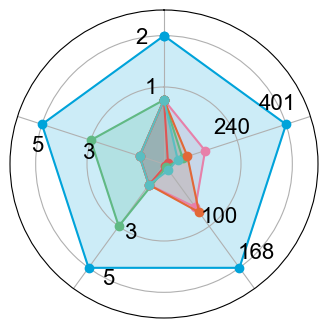

In [8]:
datasets_to_plot = ['CALCE', 'NE', 'SNL', 'HUST', 'CLO', 'This Work']
df = settings_df[['#form_factors', '#materials', '#temperatures', '#cells']]
df = df.assign(**{
    '#work_conds': settings_df['#charge_protocols'] \
        + settings_df['#discharge_protocols']})
ordered_columns = [
    '#form_factors', '#materials', '#temperatures', '#work_conds', '#cells']
df = df.loc[:, ordered_columns]

def plot_completed(ax, angles, data, line_type, color, label):
    complete_angles = np.concatenate((angles, [angles[0]]))
    complete_data = np.concatenate((data, [data.iloc[0]]))
    ax.plot(complete_angles, complete_data, line_type, color=color, label=label)
    ax.fill(complete_angles, complete_data, color=color, alpha=0.2)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='polar')
angles = np.linspace(0, 2*np.pi, len(ordered_columns), endpoint=False)
ticklabels = [
    ('Form\nFactors', 1.5),
    ('Materials', 1.35),
    ('Temperatures', 1.45),
    ('Working\nconditions', 1.3),
    ('Total\nCells', 1.5),
]
levels = [0.6, 1.0]
maxes = df.max(axis=0)

colors = ['#00A3DA', '#5ABEC1', '#E26837', '#61B984', '#E780A9', '#DF5555'][::-1]

for dataset, color in zip(datasets_to_plot, colors):
    to_plot = df.loc[dataset] / maxes
    plot_completed(ax, angles, to_plot, 'o-', color, label=dataset)
    ax.set_thetagrids(angles * 180/np.pi, df.columns)
    ax.set_theta_zero_location("N")
    ax.set_rgrids(levels, labels=[])
    ax.set_ylim([0, 1.2])
    ax.set_xticklabels([])
#     ax.legend(
#         ncols=3, fontsize=11,
#         columnspacing=1,
#         loc=(-0.05, -0.35),
#         frameon=False)
# Add the text for radar chart, to avoid the bold font problem
# for angle, (label, y) in zip(angles, ticklabels):
#     ax.text(angle, y, label, ha='center', va='center')

for angle, max_ in zip(angles, maxes.values):
    angle = angle + np.pi / 18
    for l in levels:
        ax.text(angle, l, str(int(max_ * l)), ha='center', va='center')

fig.savefig(
    HOME / 'data/dataset_radar.svg',
    bbox_inches='tight',
    pad_inches=0.1,
    transparent=True)

Reproduce Figure 2b.

100%|██████████| 403/403 [00:09<00:00, 42.31it/s] 


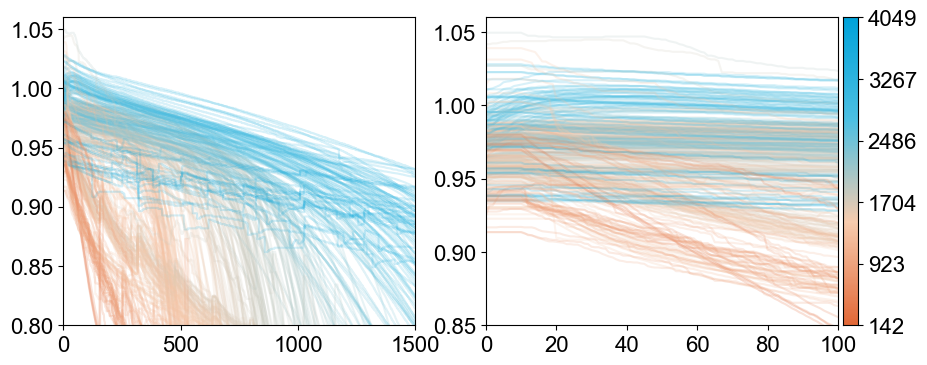

In [9]:
from scipy.signal import medfilt 
from matplotlib.colors import LinearSegmentedColormap

colors = ['#E26837', '#F7CCAE', '#4DC0E3', '#00A3DA'] 
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
max_ = 4049
min_ = 142

compare_cells = material_map['LCO']
cycle_lives = [get_cycle_life(x, 0.9) for x in compare_cells]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for battery in tqdm(all_batteries):
    capacities = np.array([
        max(x.discharge_capacity_in_Ah) for x in battery.cycle_data
    ])
    if len(capacities) < 200:
        continue
    cycle_life = get_cycle_life(battery)
    capacities = medfilt(capacities, 21) / battery.nominal_capacity_in_Ah
    if capacities[:10].mean() > 1.05:
        capacities /= 1.1
    score = (cycle_life - min_) / (max_ - min_)
    score = score ** 0.5
    color = cmap(score)
    # zorder = int(3 * (1 - score))
    zorder = 1
    ax1.plot(capacities, color=color, alpha=0.2, zorder=zorder)
    ax2.plot(capacities, color=color, alpha=0.2, zorder=zorder)
    cycle_lives.append(cycle_life)
ax1.set_ylim([0.8, 1.06])
ax1.set_xlim([0, 1500])
ax2.set_ylim([0.85, 1.06])
ax2.set_xlim([0, 100])
# plt.colorbar()
cax = ax2.inset_axes([1.01, 0, 0.05, 1.])
cax.yaxis.tick_right()
cax.yaxis.set_label_position('right')
cax.set_xticks([])
img = torch.linspace(1, 0, 1000)[None].T.expand(-1, 50)
cax.imshow(img, cmap=cmap)
yticks = [0, 200, 400, 600, 800, 1000]
labels = [int((x/1000) * (max_ - min_) + min_) for x in yticks]
cax.set_yticks(yticks, labels=labels[::-1])

fig.savefig(
    HOME / f'data/dataset.svg',
    bbox_inches='tight',
    pad_inches=0.1
)
plt.show()

Reproduce Figure 3.

In [5]:
def ranged_random_float(x_min, x_max, size):
    x = np.random.rand(size)
    return x * (x_max - x_min) + x_min

def draw_points_around(ax, x, y, width, color):
    scatter_x = ranged_random_float(x - width * 0.3, x + width * 0.3, len(y))
    ax.scatter(scatter_x, y, color=color, zorder=2)

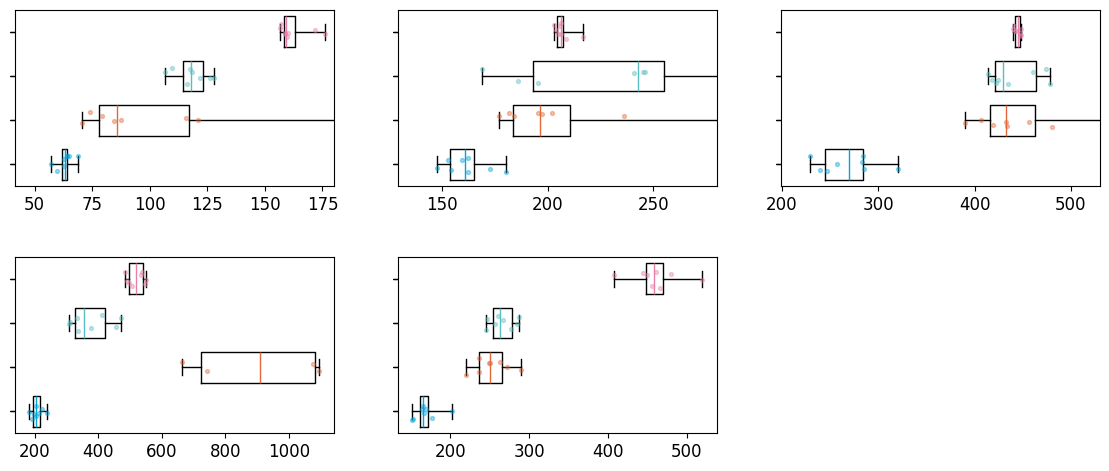

In [38]:
datasets = ['matr_1', 'matr_2', 'hust', 'mix_20', 'mix_100']
paths = [
    '../workspaces/ablation/diff_branch/batlinet/',
    '../workspaces/baselines/nn_models/cnn/',
    '../workspaces/baselines/nn_models/lstm/',
    '../workspaces/baselines/nn_models/mlp/',
]
methods = ['BatLiNet', 'CNN', 'LSTM', 'MLP']
# colors = ['#00A3DA', '#E26837', '#5ABEC1', '#61B984']
colors = ['#00A3DA', '#E26837', '#5ABEC1', '#E780A9']

plt.rcParams['font.size'] = 12
fig, axes = plt.subplots(2, 3, figsize=(14, 5.5), sharey=True)
axes = axes.reshape(-1)
axes[-1].axis('off')
ylims = [180, 280, 530, None, None, None]
for dataset, ax, lim in zip(datasets, axes, ylims):
    dataset_paths = [Path(x) / dataset for x in paths]
    for indx, (path, method, color) in enumerate(zip(
        dataset_paths, methods, colors
    )):
        rmses = []
        for log_file in path.glob('log.*'):
            with open(log_file, 'r') as f:
                rmse = float(re.findall(r'RMSE: (.*?) ', f.read())[0])
            if rmse <= 2000:
                rmses.append(rmse)
        ax.boxplot(
            rmses,
            whis=(0, 100),
            positions=[indx],
            widths=[0.7],
            vert=False,
            medianprops=dict(color=color))
        # Scatter plot
        
        fluctuation = 0.2  # Adjust the fluctuation range as needed
        y_positions = indx + np.random.uniform(-fluctuation, fluctuation, size=len(rmses))

        ax.scatter(
            rmses,
            y_positions,
            color=color,
            zorder=3,
            s=8,
            alpha=0.4
        )
    xlim = ax.get_xlim()
    if lim is not None:
        xlim = (xlim[0], lim)
    ax.set_xlim(xlim)
    ax.set_yticklabels([])
    
plt.subplots_adjust(hspace=0.4)
fig.savefig(HOME / f'data/error_range.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.rcParams['font.size'] = 14

Reproduce Figure 5a.

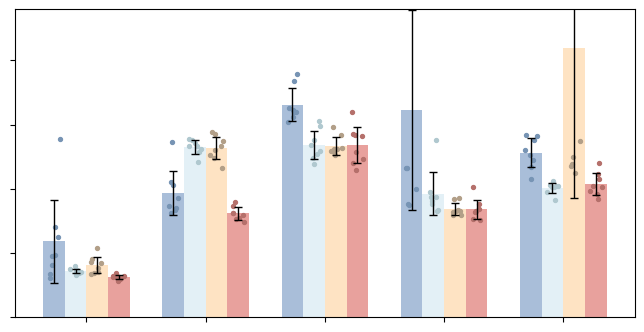

In [39]:
base_path = Path('../workspaces/ablation/diff_branch/')
methods = ['cycle_diff_only', 'cell_diff_only', 'naive_ensemble', 'batlinet']
datasets = ['matr_1', 'matr_2', 'hust', 'mix_100', 'mix_20']
dataset_names = ['MATR-1', 'MATR-2', 'HUST', 'MIX-100', 'MIX-100']
width = 1
fig, ax = plt.subplots(figsize=(8, 4))
# colors = ['#E98355', '#5ABEC1', '#E6766D', '#00A3DA']
colors = ['#A9BED9', '#E3F0F6', '#FEE3C3', '#E8A19D']

dot_colors = ['#7794B4', '#B0C8CF', '#b29f88', '#B5706B']
for indx, (method, color) in enumerate(zip(methods, colors)):
    to_plot = []
    for dataset, dataset_name in zip(datasets, dataset_names):
        path = base_path / method / dataset
        rmses = []
        for log in path.glob('log.*'):
            with open(log, 'r') as f:
                rmse = re.findall('RMSE: (.*?) ', f.read())
            rmses.append(rmse)
        if len(rmses) < 8:
            print(rmses)
            rmses = rmses + [['nan']] * (8 - len(rmses))
        to_plot.append(rmses)
    to_plot = np.array(to_plot, dtype=float)
    means, stds = np.nanmean(to_plot, axis=1), np.nanstd(to_plot, axis=1)
    x = np.arange(len(datasets))
    x = x * (len(methods)+1.5) + indx
    
    ax.bar(x, means.reshape(-1),
           width=width,
           color=color,
           yerr=stds.reshape(-1),
           error_kw=dict(capsize=3, capthick=1, lw=1),
           # error bar color is darker than grey
           ecolor='black')
    fluctuation = 0.3
    
    for i in range(to_plot.shape[1]):
        x_positions = x + np.random.uniform(-fluctuation, fluctuation, size=len(x))
        ax.scatter(x_positions, to_plot[:, i], color=dot_colors[indx], zorder=1, s=8)

    ax.set_xticks(np.arange(1.5, 28, 5.5), [])
    ax.set_ylim([0, 480])
ax.set_yticklabels([])
fig.savefig(HOME / f'data/branch_ablation.svg',
            bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()

Reproduce Figure 5b.

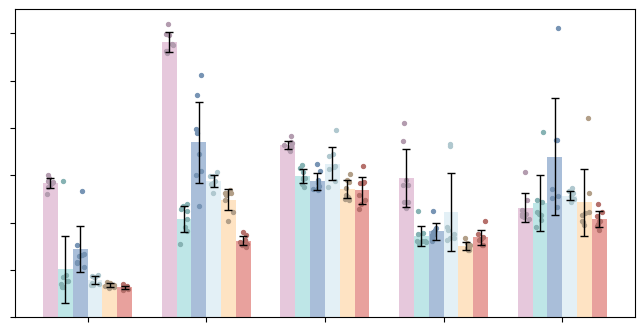

In [36]:
features = [
    'current_only', 'voltage_only',
    'charge_only', 'discharge_only',
    'raw_signals_only', 'all_features'
]
datasets = [
    'matr_1', 'matr_2', 'hust', 'mix_100', 'mix_20'
]
colors = ['#E6C8DC', '#BEE6E7', '#A9BED9', '#E3F0F6', '#FEE3C3', '#E8A19D']
dot_colors = ['#b39caf', '#86b2b3', '#7794B4', '#B0C8CF', '#b29f88', '#B5706B']

path = Path('../workspaces/ablation/feature_spaces')

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for indx, (feature, color) in enumerate(zip(features, colors)):
    to_plot = []
    for dataset in datasets:
        feature_path = path / feature / dataset
        rmses = []
        for log in feature_path.glob('log.*'):
            with open(log, 'r') as f:
                rmse = re.findall('RMSE: (.*?) ', f.read())[0]
            if float(rmse) > 1000:
                rmses.append('nan')
            else:
                rmses.append(rmse)
        to_plot.append(rmses)
    to_plot = np.array(to_plot, dtype=float)
    means, stds = np.nanmean(to_plot, axis=1), np.nanstd(to_plot, axis=1)
    x = np.arange(len(datasets))
    x = x * (len(features)+2) + indx
    ax.bar(x, means.reshape(-1),
           width=1,
           color=color,
           yerr=stds.reshape(-1),
           error_kw=dict(capsize=3, capthick=1, lw=1),
           # error bar color is darker than grey
           ecolor='black')
    fluctuation = 0.3
    for i in range(to_plot.shape[1]):
        x_positions = x + np.random.uniform(-fluctuation, fluctuation, size=len(x))
        ax.scatter(x_positions, to_plot[:, i], color=dot_colors[indx],zorder=1, s=8)
    ax.set_xticks(np.arange(2.5, 42, 8), [])
    # ax.set_ylim([0, 480])
ax.set_yticklabels([])
fig.savefig(HOME / f'data/feature_ablation.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

Reproduce Figure 6a.

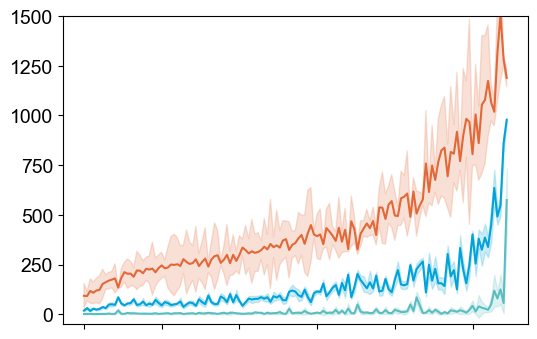

In [ ]:
# Load the data from the predictions
# For all seeds, do
# 1. load the checkpoint
# 2. manually run forward, get the per-support instance predictions
path = Path('../workspaces/ablation/diff_branch/batlinet/mix_100')
device = 'cuda:0'
in_C, C, H, W = 6, 32, 100, 1000
model = MODELS.build({
    'name': 'BatLiNetRULPredictor',
    'in_channels': in_C,
    'channels': C,
    'input_height': H,
    'input_width': W,
    'support_size': 32,
    'test_batch_size': 1,
    'return_pointwise_predictions': True
})
model = model.to(device)
model.eval()

maxes, mins, meds = [], [], []

for seed in range(8):
    ckpt_file = next(path.glob(f'*_{seed}_epoch_1000.ckpt'))
    pred_file = next(path.glob(f'*seed_{seed}_*.pkl'))
    with open(pred_file, 'rb') as f:
        preds = pickle.load(f)
        data = preds['data'].to(device)
    model.load_checkpoint(ckpt_file)
    predictions = model.predict(data)[1]
    # inverse transform
    predictions = data.label_transformation.inverse_transform(predictions)
    labels = data.label_transformation.inverse_transform(data.test_data.label)
    # Errors
    errors = (predictions - labels[:, None]).abs()
    med, max_, min_ = errors.median(1)[0], errors.amax(1), errors.amin(1)
    meds.append(med.cpu())
    mins.append(min_.cpu())
    maxes.append(max_.cpu())

maxes, mins, meds = torch.stack(maxes), torch.stack(mins), torch.stack(meds)

_, order = (sum([
    mins.mean(0), maxes.mean(0), meds.mean(0)
])/3).sort()

colors = ['#00A3DA', '#E26837', '#5ABEC1']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x = torch.arange(meds.shape[1])

ax.plot(x, meds.mean(0)[order], color=colors[0])
ax.fill_between(
    x, meds.mean(0)[order] - meds.std(0)[order],
    meds.mean(0)[order] + meds.std(0)[order],
    color=colors[0], alpha=0.2)
ax.plot(x, maxes.mean(0)[order], color=colors[1])
ax.fill_between(
    x, maxes.mean(0)[order] - maxes.std(0)[order],
    maxes.mean(0)[order] + maxes.std(0)[order],
    color=colors[1], alpha=0.2)
ax.plot(x, mins.mean(0)[order], color=colors[2])


ax.fill_between(
    x, mins.mean(0)[order] - mins.std(0)[order],
    mins.mean(0)[order] + mins.std(0)[order],
    color=colors[2], alpha=0.2)
ax.set_xticklabels([])
# Move the yticks to the right of the figure
# ax.yaxis.tick_right()
ax.set_ylim([-50, 1500])
fig.savefig(HOME / f'data/sup_choice_mix_100.svg',
            bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()


Reproduce Figure 6b.

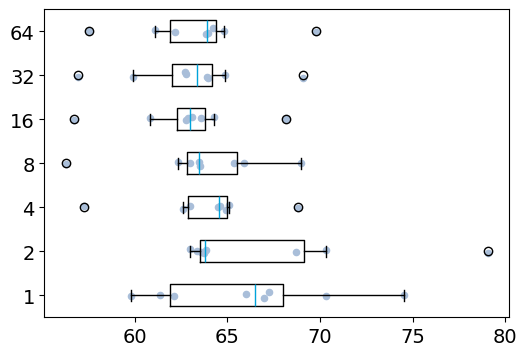

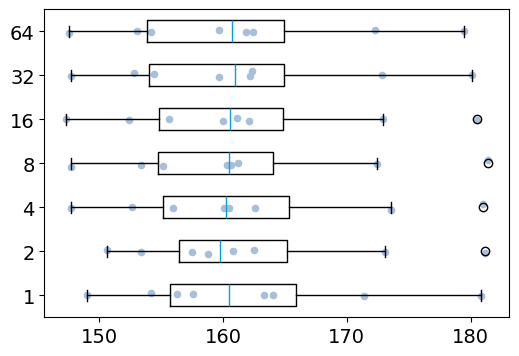

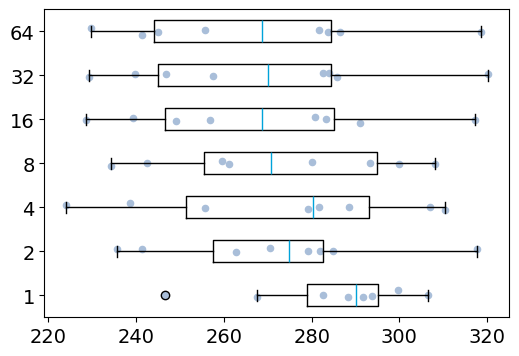

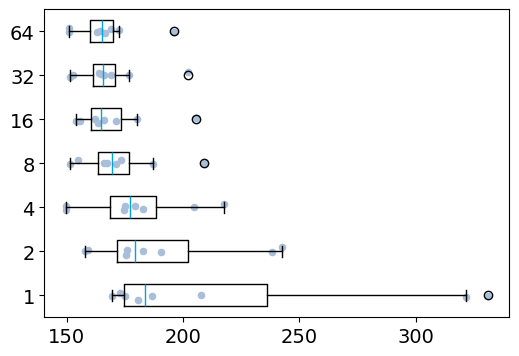

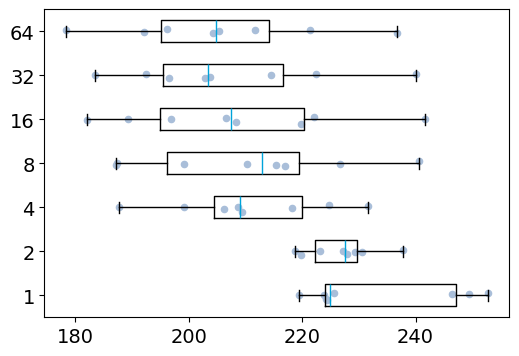

In [78]:
method_names = ['BatLiNet', 'Cell-difference only', 'Cycle-difference only']
datasets = ['matr_1', 'matr_2', 'hust', 'mix_100', 'mix_20']
dataset_names = ['MATR-1', 'MATR-2', 'HUST', 'MIX-100', 'MIX-20']
path = Path('../workspaces/ablation/test_support_size/')
colors = ['#00A3DA', '#5ABEC1', '#E26837']
sup_sizes = [1, 2, 4, 8, 16, 32, 64]
for dataset, dataset_name in zip(datasets, dataset_names):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    curves = []
    for sup_size in sup_sizes:
        model_path = path / str(sup_size) / dataset
        scores = []
        for log_path in model_path.glob('log.*'):
            with open(log_path, 'r') as f:
                rmse = float(re.findall('RMSE: (.*?) ', f.read())[0])
            scores.append(rmse)
        curves.append(scores)
    to_plot = np.array(curves).T
    ax.boxplot(to_plot, medianprops=dict(color=colors[0]), vert=False)

    for i, data in enumerate(to_plot.T):
        y = np.random.normal(i + 1, 0.04, size=len(data))  # Add some jitter for better visibility
        ax.scatter(data, y, alpha=1, s=20, color='#A9BED9')

    if dataset == 'mix':
        xlim = ax.get_xlim()
        ax.set_xlim([143, 189])
    ax.set_yticks(np.arange(1, 8), labels=sup_sizes)
    fig.savefig(HOME / f'data/test_sup_size_{dataset_name}.svg',
                bbox_inches='tight', pad_inches=0.1, transparent=True)
    plt.show()

In [15]:
import inspect
from torch.utils import benchmark

def var_dict(*args):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return dict([
        (name, val) for name, val in callers_local_vars if val is arg
    ][0] for arg in args)

def walltime(stmt, arg_dict, duration=3):
    timer = benchmark.Timer(stmt=stmt, globals=arg_dict)\
                     .blocked_autorange(min_run_time=duration)
    return timer

device = 'cuda:0'
in_C, C, H, W = 6, 32, 100, 1000

model = MODELS.build({
    'name': 'BatLiNetRULPredictor',
    'in_channels': in_C,
    'channels': C,
    'input_height': H,
    'input_width': W
})
model = model.to(device).half()
model.eval()

sup_sizes = [1, 2, 4, 8, 16, 32, 64]
batch_sizes = np.array([128, 64, 32, 16, 8, 4, 2]) * 4
results = []
with torch.no_grad():
    for sup_size, batch_size in zip(sup_sizes, batch_sizes):
        x = torch.rand([batch_size, in_C, H, W], device=device).half()
        sup_x = torch.rand([batch_size, sup_size, in_C, H, W], device=device).half()
        y = torch.rand([batch_size, 1], device=device).half()
        sup_y = torch.rand([batch_size, sup_size, 1], device=device).half()
        t = walltime(
            'model(x, y, sup_x, sup_y)', var_dict(model, x, y, sup_x, sup_y))
        max_, min_, med = max(t.times), min(t.times), t.median
        results.append((batch_size / med, batch_size / max_, batch_size / min_))
        del x, sup_x, y, sup_y

[8736.615402619584, 5795.9899276364895, 3465.579895973564, 1926.471696107597, 1016.0278930995794, 521.9732292080973, 265.4802513817954]


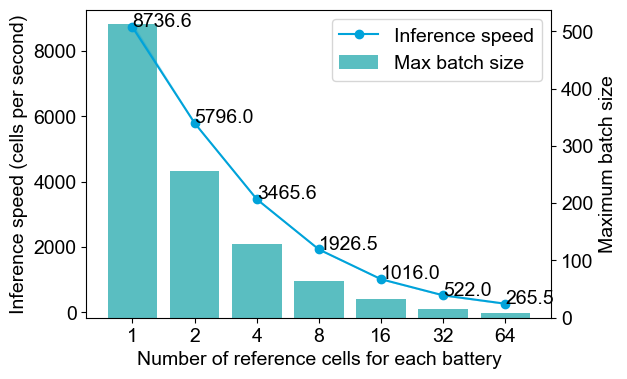

In [16]:
colors = ['#00A3DA', '#5ABEC1']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
tax = ax.twinx()

print([res[0] for res in results])
x = np.arange(len(results))
tax.bar(x, batch_sizes, color=colors[1], label='Max batch size')
ax.set_xticks(np.arange(len(results)), sup_sizes)
ax.plot(
    x, [res[0] for res in results], 'o-',
    color=colors[0], label='Inference speed')
ax.fill_between(
    x, [res[1] for res in results],
    [res[2] for res in results],
    alpha=0.2, color=colors[0], zorder=2)
ax.set_zorder(tax.get_zorder()+1)
ax.set_frame_on(False)

for i, num in enumerate(results):
    ax.text(i, num[0], f'{num[0]:.1f}')

ax.set_ylabel('Inference speed (cells per second)')
tax.set_ylabel('Maximum batch size')
ax.set_xlabel('Number of reference cells for each battery')

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = tax.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2

leg = ax.legend(handles, labels)

# tax.set_ylim([0, 180])
# ax.set_ylim([0, 3500])

fig.savefig(HOME / f'data/running_time_half_precision.svg',
            bbox_inches='tight', pad_inches=0.1, transparent=True)
plt.show()

Reproduce Figure 7a.

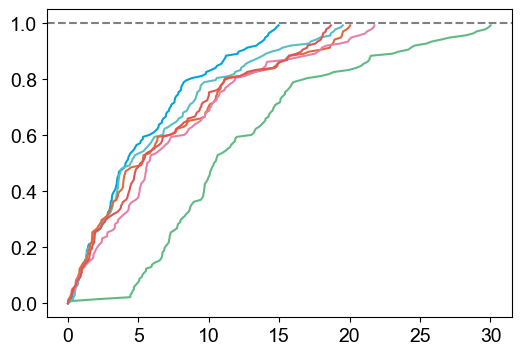

In [17]:
paths = [
    '../workspaces/ablation/diff_branch/batlinet/mix_100',
    '../workspaces/baselines/nn_models/cnn/mix_100',
    '../workspaces/baselines/nn_models/lstm/mix_100',
    '../workspaces/baselines/nn_models/mlp/mix_100',
    '../workspaces/baselines/sklearn/svm/mix_100',
    '../workspaces/baselines/sklearn/rf/mix_100',
]
methods = ['BatLiNet', 'CNN', 'LSTM', 'MLP', 'SVM', 'RF']
# colors = ['#00A3DA', '#E26837', '#5ABEC1', ]
colors = ['#00A3DA', '#5ABEC1', '#E26837', '#61B984', '#E780A9', '#DF5555']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for path, method, color in zip(paths, methods, colors):
    path = Path(path)
    pred_path = next(path.glob('pred*.pkl'))
    with open(pred_path, 'rb') as f:
        preds = pickle.load(f)
    label_tf = preds['data'].label_transformation
    labels = label_tf.inverse_transform(preds['data'].test_data.label.cpu())
    preds = label_tf.inverse_transform(preds['prediction'].cpu())
    # error, _ = (labels - preds).abs().sort()
    error = (labels - preds).abs()
    error = torch.cat([torch.tensor([0]), error, ])
    x = np.arange(len(error)) / len(error)
    ax.plot(torch.cumsum(error, 0) / 1000, x, label=method, color=color)

xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.hlines([1], xlim[0], xlim[1], color='grey', linestyles='dashed')
ax.set_xlim(xlim)
# plt.legend()
fig.savefig(HOME / f'data/cum_error.svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

Reproduce Figure 7b-f.

Err within 10%: tensor(0.7619)
Err within 20%: tensor(1.)


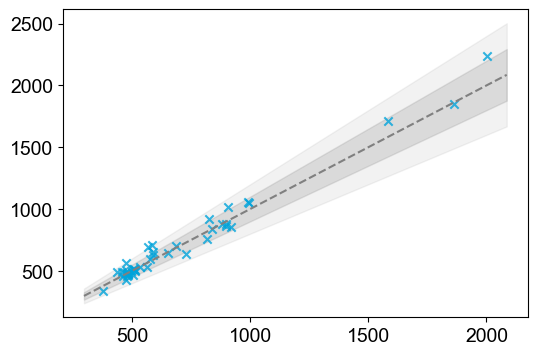

Err within 10%: tensor(0.5500)
Err within 20%: tensor(0.8750)


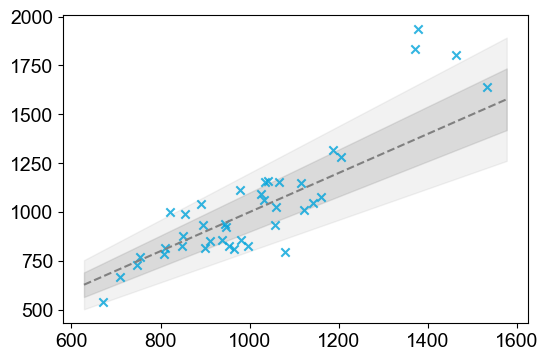

Err within 10%: tensor(0.7273)
Err within 20%: tensor(0.8636)


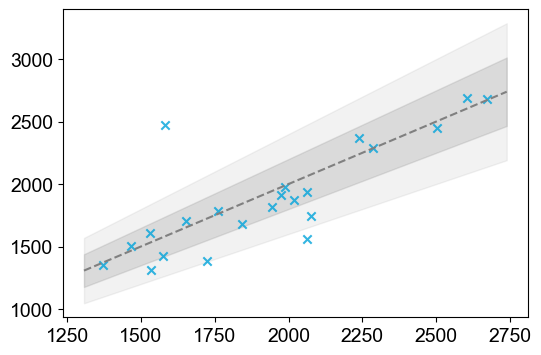

Err within 10%: tensor(0.3605)
Err within 20%: tensor(0.7007)


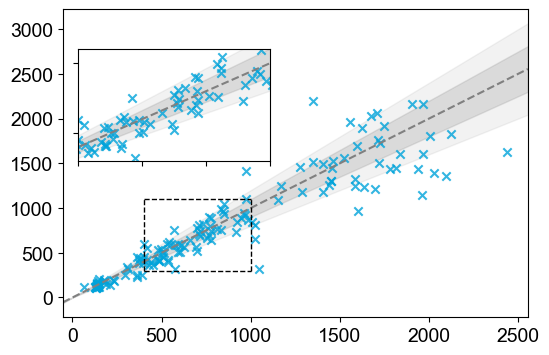

Err within 10%: tensor(0.6788)
Err within 20%: tensor(0.8905)


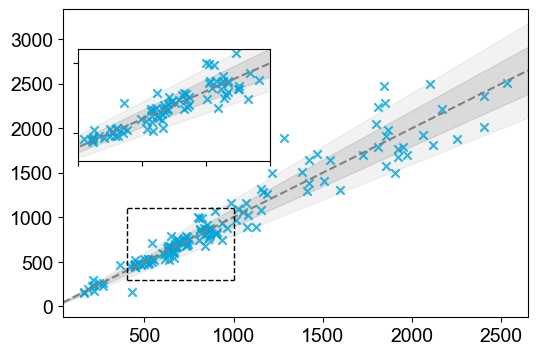

In [21]:
method_names = ['BatLiNet', 'Cell-difference only', 'Cycle-difference only']
datasets = ['matr_1', 'matr_2', 'hust', 'mix_20', 'mix_100']
dataset_names = ['MATR-1', 'MATR-2', 'HUST', 'MIX-20', 'MIX-100']
method_paths = [
    '../workspaces/ablation/diff_branch/batlinet/',
    '../workspaces/ablation/diff_branch/cell_diff_only/',
    '../workspaces/ablation/diff_branch/cycle_diff_only/',
]
colors = ['#00A3DA', '#5ABEC1', '#E26837']
markers = ['x', 'o', '^']
boxes = [
    # [[400, 1000], [300, 1100]],
    # [[420, 700], [400, 700]],
    None,
    None,
    None,
    [[400, 1000], [300, 1100]],
    [[400, 1000], [300, 1100]],
]
for dataset, dataset_name, box_to_show in zip(datasets, dataset_names, boxes):
    paths = [Path(x+dataset) for x in method_paths]
    for method, method_path, color, marker in zip(
        method_names, paths, colors, markers
    ):
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        if box_to_show is not None:
            ax2 = fig.add_axes([0.15, 0.5, 0.32, 0.28])
        data = next(method_path.glob('*seed_0_*.pkl'))
        with open(data, 'rb') as f:
            data = pickle.load(f)
            pred = data['data'].label_transformation.inverse_transform(
                data['prediction'].to('cpu'))
            label = data['data'].label_transformation.inverse_transform(
                data['data'].test_data.label.to('cpu'))
        # pred, label = pred.log(), label.log()
        ax.scatter(pred, label, color=color, marker=marker, alpha=0.8)
        if box_to_show is not None:
            ax2.scatter(pred, label, color=color, marker=marker, alpha=0.8)
        # Plot y=x in grey color, dashed and alpha is 0.5
        xlim = ax.get_xlim()
        x = torch.linspace(*xlim, 100)
        # x = np.linspace(label.min(), label.max(), 100)
        ax.plot(x, x, color='grey', linestyle='--')
        if box_to_show is not None:
            ax2.plot(x, x, color='grey', linestyle='--')
        # # Plot the x% error area, filled with grey, low alpha and zorder
        range_ = 10 / 100
        y1 = (1 - range_) * x
        y2 = (1 + range_) * x
        ax.fill_between(x, y1, y2, color='grey', alpha=0.2, zorder=-1)
        print(
            'Err within 10%:',
            ((pred > label * 0.9) & (pred < label * 1.1)).sum() / len(pred))
        if box_to_show is not None:
            ax2.fill_between(x, y1, y2, color='grey', alpha=0.2, zorder=-1)
        range_ = 20 / 100
        y1 = (1 - range_) * x
        y2 = (1 + range_) * x
        ax.fill_between(x, y1, y2, color='grey', alpha=0.1, zorder=-1)
        print(
            'Err within 20%:',
            ((pred > label * 0.8) & (pred < label * 1.2)).sum() / len(pred))
        if box_to_show is not None:
            ax2.fill_between(x, y1, y2, color='grey', alpha=0.1, zorder=-1)

        if box_to_show is not None:
            ax.vlines(box_to_show[0], *box_to_show[1],
                      linewidth=1, linestyle='--', color='black')
            ax.hlines(box_to_show[1], *box_to_show[0],
                      linewidth=1, linestyle='--', color='black')
            ax.set_xlim(xlim)

            ax2.set_xlim(box_to_show[0])
            ax2.set_ylim(box_to_show[1])
            ax2.set_xticklabels([])
            ax2.set_yticklabels([])

        fig.savefig(HOME / f'data/instance_level_err_{dataset_name}.svg',
                    bbox_inches='tight', pad_inches=0.1, transparent=True)
        break
    plt.show()
